**import**

In [1]:
import os #functions for interacting with the operating system.
from PIL import Image #adds support for opening, manipulating, and saving many different image file formats.
'''image:- module provides a class with the same name which is used to represent a PIL image. The module also provides a number of factory functions, 
including functions to load images from files, and to create new images.'''
import matplotlib.pyplot as plt #for creating static, animated, and interactive visualizations

import torch #a framework that provides a wide range of algorithms for deep learning
import torchvision #consists of datasets, model architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, Dataset, random_split
'''data loading utility, represents a Python iterable over a dataset'''
'''argument of DataLoader constructor is dataset, which indicates a dataset object to load data from. PyTorch'''
'''Randomly split a dataset into non-overlapping new datasets of given lengths.'''
import torchvision.transforms as transforms
#control over the transformations. This is useful if you have to build a more complex transformation pipeline (e.g. in the case of segmentation tasks).

**Dataset to Torchvision Dataset**

In [2]:
#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

import copy

train_on_gpu = torch.cuda.is_available()

**Enabling GPU**

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

**Data Loader**

In [5]:
os.mkdir('../Inputs')

import zipfile

# Will unzip the files so that you can see them..
with zipfile.ZipFile("../input/padhai-tamil-vowel-consonant-classification/train.zip","r") as z:
    z.extractall("../Inputs/")
with zipfile.ZipFile("../input/padhai-tamil-vowel-consonant-classification/test.zip","r") as z:
    z.extractall("../Inputs/")

In [6]:
transform = transforms.Compose([
    transforms.ColorJitter(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), ])

In [7]:
batch_size = 60 #number of samples to work through before updating the internal model parameters. Size of Training Set
full_data=VowelConsonantDataset("../Inputs/train",train=True,transform=transform)
# we are splitting total 10000 images into 9000 images for training and remaining 1000 for validation
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

test_data=VowelConsonantDataset("../Inputs/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=60,shuffle=False)

**Data Visualization**

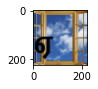

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
img = images[1]
npimg = img.numpy()
npimg = np.transpose(npimg, (1, 2, 0))
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()

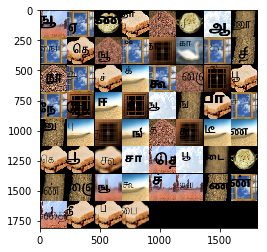

In [9]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(images))

**Model**

In [10]:
from torchvision import models

In [11]:
class MyModel(nn.Module):
    def __init__(self, num_classes1, num_classes2):
        super(MyModel,self).__init__()
        #model architectures for image classification:- mobilenet
        self.model_snet = models.mobilenet_v2(pretrained=True)
        self.model_snet.classifier = nn.Sequential(nn.Dropout(p=0.2))
        #Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data.
        
        self.fc1 = nn.Linear(1280,num_classes1,bias=True) #input=1280 num_classes1(output)=10
        #Applies a linear transformation to the incoming data, i.e. //y= Ax+b//.
        #The input tensor given in forward(input) must be either a vector (1D tensor) or matrix (2D tensor).
        '''linear1=torch.nn.Linear(N_FEATURES, hiddenLayerSize, bias=True) 
            torch.nn.init.xavier_uniform(linear1.weight)'''
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        #weight initializer function
        torch.nn.init.zeros_(self.fc1.bias)
        #Returns a tensor filled with the scalar value 0, with the same size as input.
        
        self.fc2 = nn.Linear(1280,num_classes2,bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc2.bias)
        
    def forward(self,x): # Forward pass: compute predicted y
        x = self.model_snet(x)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        return out1,out2

In [12]:
net  = MyModel(10,10) # Dataset contains 10 classes of vowel & 10 consonent.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [13]:
net = net.to(device)

**Evaluation**

In [14]:
#to Compute accuracy
def evaluation(dataloader):
    
    total, correct = 0, 0
    for data in dataloader:
        #iterate over each data from dataloader 
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Extracting Actual Labels
        _, actual_v = torch.max(labels[:,0,:].data, 1) #actual vowel
        _, actual_c = torch.max(labels[:,1,:].data, 1) #actual consonent
        
        outputs_v,outputs_c = net(inputs)
        _, pred_v = torch.max(outputs_v.data, 1) #predicted vowel
        _, pred_c = torch.max(outputs_c.data, 1) #predicted consonent
        
        total += labels.size(0)
        correct_v = (pred_v == actual_v)*1 #correct vowel
        correct_c = (pred_c == actual_c)*1 #correct consonent
        correct_v[correct_v == 0] = 2 #if value = 0
        correct_c[correct_c == 0] = 3
        correct += ((correct_v==correct_c)).sum().item()
    return 100 * correct / total # Prediction Percentage


**Optimization**

In [15]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
# Initialize the params, put together the arguments for the optimizer

plist = [
        {'params': net.fc1.parameters(), 'lr': 5e-3},
        {'params': net.fc2.parameters(), 'lr': 5e-3}
        ]
        #parameters will use a learning rate of 5e-3
    
lr=0.01
# an SGD optimizer
opt = optim.SGD(net.parameters(),lr=0.01,momentum=0.9,nesterov=True)
'''Once gradients have been computed using loss.backward(), calling optimizer.step() updates the parameters as defined by the optimization algorithm.'''
# nestrov GD reduce the oscillation
# opt = optim.Adam(my_model.parameters(),lr=0.01)

'Once gradients have been computed using loss.backward(), calling optimizer.step() updates the parameters as defined by the optimization algorithm.'

**Training**

Epoch: 0/10, Test acc: 84.40, Train acc: 87.59
Epoch: 1/10, Test acc: 86.70, Train acc: 91.12
Epoch: 2/10, Test acc: 88.20, Train acc: 93.28
Epoch: 3/10, Test acc: 89.70, Train acc: 94.76
Epoch: 4/10, Test acc: 89.90, Train acc: 96.67
Epoch: 5/10, Test acc: 90.80, Train acc: 97.34
Epoch: 6/10, Test acc: 91.20, Train acc: 98.09
Epoch: 7/10, Test acc: 91.20, Train acc: 97.91
Epoch: 8/10, Test acc: 90.90, Train acc: 98.59
Epoch: 9/10, Test acc: 91.40, Train acc: 98.62


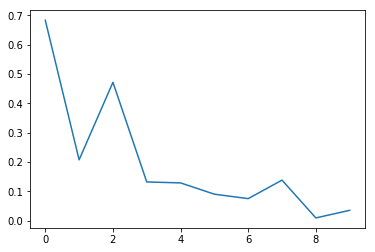

CPU times: user 9min 39s, sys: 5min 25s, total: 15min 5s
Wall time: 15min 9s


In [16]:
%%time
#Epoch:- number times that the learning algorithm will work through the entire training dataset.
loss_arr = []
loss_epoch_arr = []
max_epochs = 10
min_loss = 1000
best_model = None
for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):
        # enumerate() returns a tuple containing a count (from start which defaults to 0) and the values obtained from iterating over iterable.
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels_v = labels[:,0,:] #vowel
        labels_c = labels[:,1,:] #consonent
        _, actual_v = torch.max(labels_v.data, 1)
        _, actual_c = torch.max(labels_c.data, 1)
        opt.zero_grad() # Sets gradients of all model parameters to zero,so parameter update correctly
        
        outputs_v, outputs_c = net(inputs)
        loss_v = loss_fn(outputs_v, actual_v) #loss in vowel
        loss_c = loss_fn(outputs_c, actual_c) #loss in consonent
        loss = torch.add(loss_v,loss_c)
        loss.backward() #backward pass:- computes the derivative of the loss w.r.t. the parameters
        opt.step() #causes the optimizer to take a step based on the gradients of the parameters.
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(net.state_dict()) #create a fully independent clone of the original object and all of its children.
        
        loss_arr.append(loss.item())
        
        del inputs, labels, outputs_v, outputs_c
        torch.cuda.empty_cache() ##to empty the unused memory after processing each batch
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(validation_loader), evaluation(train_loader)))
    
net.load_state_dict(best_model) #Selecting the best model
plt.plot(loss_epoch_arr)
plt.show()

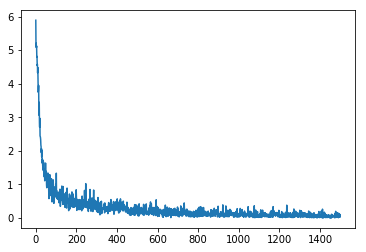

In [17]:
plt.plot(loss_arr)
plt.show()

In [18]:
evaluation(validation_loader)

91.8